In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold,train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read the file
ff=pd.read_csv("E:/ExcelR/Assignments/Data Science Assignments/16.Neural Networks/forestfires.csv")
ff.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [3]:
# describing file to check for null values,shapes and data type
ff.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

In [4]:
ff.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

No null values found.Shape of data is(517,31), where 1st and 2nd column month, day column are already encoded so we drop these columns and label encode for column "size category"(y variable) as other all columns are numerical.

In [5]:
#size_category - large:0 & small:1
ff=ff.drop(["month","day"], axis=1)
labelencoder = LabelEncoder()
ff["size_category"] = labelencoder.fit_transform(ff["size_category"])
print(ff.shape)
ff.head()

(517, 29)


,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,1,0,0,0,0,1
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,1
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,1
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,1,0,0,0,0,1
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,1,0,0,0,0,1


In [7]:
pd.concat([ff.iloc[:,0:9],ff.iloc[:,-1]],axis = 1).describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,0.731141
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,0.443796
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,1.000000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,1.000000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,1.000000


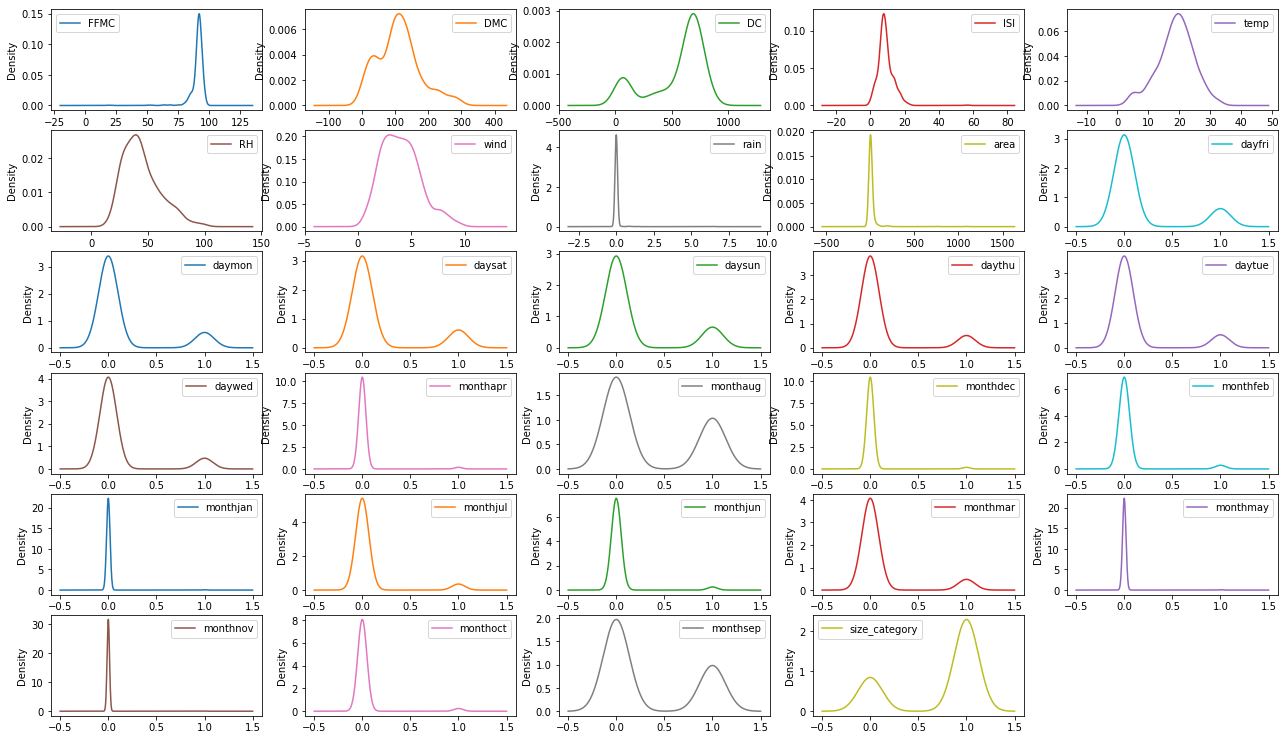

In [8]:
ff.plot(kind="kde",subplots=True,layout=(6,5),sharex=False,sharey=False,figsize=(22,13))
plt.show();

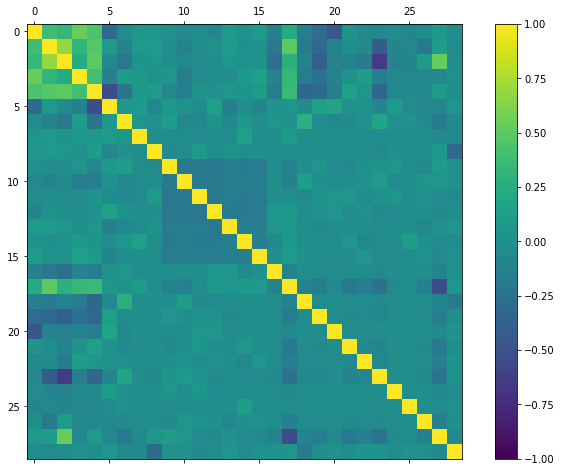

In [9]:
# correlation matrix
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(ff.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show();

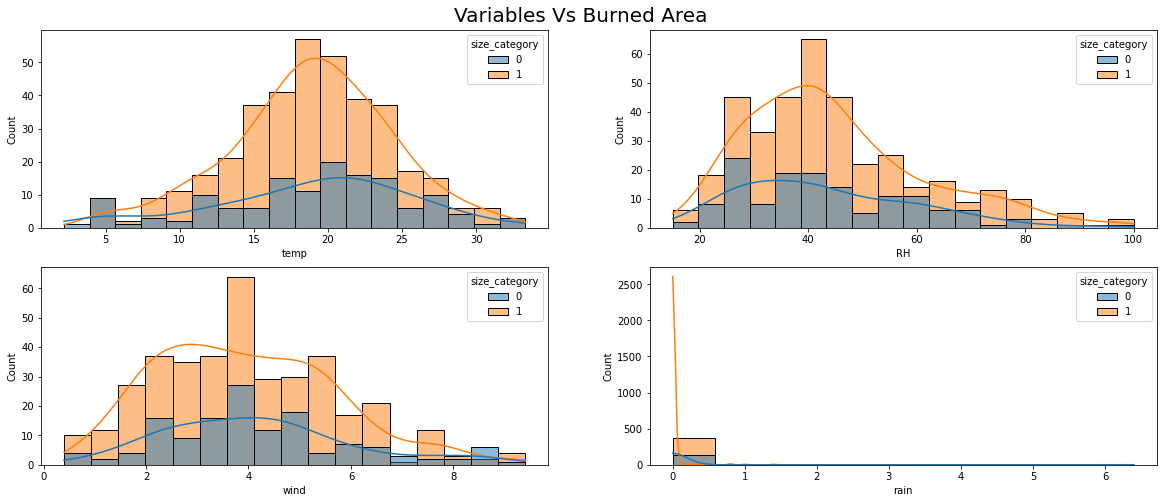

In [10]:
#variables affecting Burned Area 
fig = plt.figure(figsize=(20,8))
plt.suptitle("Variables Vs Burned Area", size=20, y=.92) 

plt.subplot(2,2,1)
sns.histplot(x="temp",data=ff,kde=True,hue="size_category")#Temperature
plt.subplot(2,2,2)
sns.histplot(x="RH",data=ff,kde=True,hue="size_category")#Relative Humidity
plt.subplot(2,2,3)
sns.histplot(x="wind",data=ff,kde=True,hue="size_category")
plt.subplot(2,2,4)
sns.histplot(x="rain",data=ff,kde=True,hue="size_category")
plt.show();

In [11]:
# split data into X and Y variables
X = ff.iloc[:,0:-1]
Y = ff.iloc[:,-1]

In [12]:
# Standardization,fit,transform and describe the dataset
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)
pd.DataFrame(X_standardized).describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,...,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,-1.754024e-15,3.070830e-16,7.387171e-17,-3.865380e-17,2.005703e-16,3.362881e-16,-2.676776e-16,-2.841054e-16,-1.274502e-16,4.874674e-17,...,7.179943e-16,-1.933764e-16,-2.260174e-17,1.352883e-17,1.169277e-16,2.265542e-16,-2.596515e-16,1.443075e-16,6.253326e-16,4.024290e-16
std,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,...,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00,1.000969e+00
min,-1.304582e+01,-1.715608e+00,-2.179108e+00,-1.980578e+00,-2.876943e+00,-1.796637e+00,-2.021098e+00,-7.326831e-02,-2.020198e-01,-4.435755e-01,...,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,-6.231770e-02,-4.402255e-02,-1.728597e-01,-7.060812e-01
25%,-8.063453e-02,-6.606652e-01,-4.448281e-01,-5.535954e-01,-5.842379e-01,-6.924563e-01,-7.361236e-01,-7.326831e-02,-2.020198e-01,-4.435755e-01,...,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,-6.231770e-02,-4.402255e-02,-1.728597e-01,-7.060812e-01
50%,1.732292e-01,-4.020255e-02,4.691190e-01,-1.364774e-01,7.082076e-02,-1.403660e-01,-9.833712e-03,-7.326831e-02,-1.938429e-01,-4.435755e-01,...,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,-6.231770e-02,-4.402255e-02,-1.728597e-01,-7.060812e-01
75%,4.089598e-01,4.927389e-01,6.696628e-01,3.904086e-01,6.741643e-01,5.344111e-01,4.929823e-01,-7.326831e-02,-9.870852e-02,-4.435755e-01,...,-1.331035e-01,-2.006027e-01,-6.231770e-02,-2.568645e-01,-1.843909e-01,-3.415123e-01,-6.231770e-02,-4.402255e-02,-1.728597e-01,1.416268e+00
max,1.007353e+00,2.819865e+00,1.261610e+00,1.033538e+01,2.484195e+00,3.417549e+00,3.007063e+00,2.157228e+01,1.695111e+01,2.254407e+00,...,7.512952e+00,4.984977e+00,1.604681e+01,3.893103e+00,5.423261e+00,2.928152e+00,1.604681e+01,2.271563e+01,5.785038e+00,1.416268e+00


In [13]:
# #creating model by hypertuning its parameter using grid search CV
# def create_model(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
#     model = Sequential()
#     model.add(Dense(neuron1,input_dim = 28,kernel_initializer = init,activation = activation_function))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1,activation = "sigmoid"))
    
#     adam = Adam(lr = learning_rate)
#     model.compile(loss = "binary_crossentropy",optimizer = adam,metrics = ["accuracy"])
#     return model

# # Create the model

# model = KerasClassifier(build_fn = create_model,verbose = 0)

# # Define the grid search parameters

# batch_size = [10,20]
# epochs = [10,50]
# learning_rate = [0.01,0.1]
# dropout_rate = [0.0,0.1]
# activation_function = ["softmax","relu"]
# init = ["uniform","normal"]
# neuron1 = [4,8,16]
# neuron2 = [2,4,8]

# # Make a dictionary of the grid search parameters

# param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
#                    activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# # Build and fit the GridSearchCV

# grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10)
# grid_result = grid.fit(X_standardized,Y)

# # Summarize the results
# print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print('{},{} with: {}'.format(mean, stdev, param))

**Results from GridSearchCV 
Best : 0.9399925231933594, using {'activation_function': 'softmax', 'batch_size': 10, 'dropout_rate': 0.0,'epochs': 50, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 4, 'neuron2': 8}**       
*Note:since the output took long to execute so just run it once and converted as markdown*

In [14]:
# Defining the model as per grid search output
def create_model():
    model = Sequential()
    model.add(Dense(4,input_dim = 28,kernel_initializer = "uniform",activation = "softmax"))
    model.add(Dropout(0.0))
    model.add(Dense(8,kernel_initializer = "uniform",activation = "softmax"))
    model.add(Dropout(0.0))
    model.add(Dense(1,activation = "sigmoid"))
    
    adam = Adam(lr = 0.01)
    model.compile(loss = "binary_crossentropy",optimizer = adam,metrics = ["accuracy"])
    return model

# Create the model
model = KerasClassifier(build_fn = create_model,batch_size = 10,epochs = 50)

# Fitting the model
model.fit(X_standardized,Y)

# Predicting using trained model
Y_predict = model.predict(X_standardized)

#Printing its metrics
print(round(accuracy_score(Y,Y_predict)*100,2),"%")

Epoch 1/50
52/52 [==============================] - 1s 2ms/step - loss: 0.6227 - accuracy: 0.7002
Epoch 2/50
52/52 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7311
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7311
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.5272 - accuracy: 0.7311
Epoch 5/50
52/52 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7872
Epoch 6/50
52/52 [==============================] - 0s 1ms/step - loss: 0.3955 - accuracy: 0.8646
Epoch 7/50
52/52 [==============================] - 0s 1ms/step - loss: 0.3241 - accuracy: 0.8956
Epoch 8/50
52/52 [==============================] - 0s 1ms/step - loss: 0.2541 - accuracy: 0.9149
Epoch 9/50
52/52 [==============================] - 0s 1ms/step - loss: 0.2089 - accuracy: 0.9420
Epoch 10/50
52/52 [==============================] - 0s 2ms/step - loss: 0.1839 - accuracy: 0.9362
Epoch 11/50
52/52 [

In [15]:
#Building Model based on Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y, test_size = 0.33, random_state = 5)

def final_model():
    model = Sequential()
    model.add(Dense(4,input_dim = 28,kernel_initializer = "uniform",activation = "softmax"))
    model.add(Dropout(0.0))
    model.add(Dense(8,kernel_initializer = "uniform",activation = "softmax"))
    model.add(Dropout(0.0))
    model.add(Dense(1,activation = "sigmoid"))
    
    adam = Adam(lr = 0.01)
    model.compile(loss = "binary_crossentropy",optimizer = adam,metrics = ["accuracy"])
    return model

# Create the model
model = KerasClassifier(build_fn = final_model,batch_size = 10,epochs = 50)

# Fitting the model
model.fit(X_train,Y_train)

# Predicting using trained model
Y_predict = model.predict(X_test)

# Printing the metrics
print(round(accuracy_score(Y_test,Y_predict)*100,2),"%")

Epoch 1/50
35/35 [==============================] - 1s 2ms/step - loss: 0.6438 - accuracy: 0.6850
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5959 - accuracy: 0.7197
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5868 - accuracy: 0.7197
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5782 - accuracy: 0.7197
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7197
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.7197
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.7861
Epoch 8/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3983 - accuracy: 0.8555
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.3323 - accuracy: 0.8960
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.9191
Epoch 11/50
35/35 [

In [16]:
story=model.fit(X_standardized,Y,validation_split=0.33,epochs=50,batch_size=10)

Epoch 1/50
35/35 [==============================] - 1s 13ms/step - loss: 0.6216 - accuracy: 0.7341 - val_loss: 0.6279 - val_accuracy: 0.6784
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5585 - accuracy: 0.7572 - val_loss: 0.6343 - val_accuracy: 0.6784
Epoch 3/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5493 - accuracy: 0.7572 - val_loss: 0.6343 - val_accuracy: 0.6784
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5372 - accuracy: 0.7572 - val_loss: 0.6242 - val_accuracy: 0.6784
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5079 - accuracy: 0.7572 - val_loss: 0.6010 - val_accuracy: 0.6784
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7630 - val_loss: 0.5631 - val_accuracy: 0.7076
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8497 - val_loss: 0.4966 - val_accuracy: 0.8070
Epoch 8/50
35/35 [=

In [17]:
# list all data in history from story as dictionary in key format from keras 
story.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

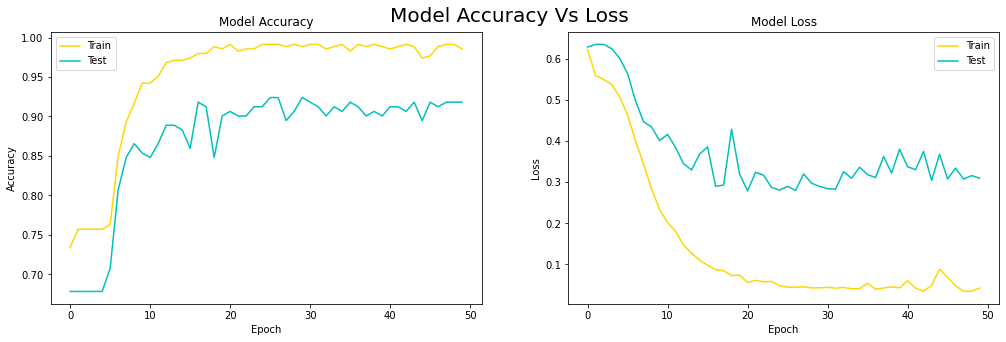

Accuracy of model : 87.22 %
Loss of model     : 37.0 %


In [18]:
# visualize history for accuracy & loss
fig = plt.figure(figsize=(17,5))
plt.suptitle("Model Accuracy Vs Loss", size=20, y=.95) 
plt.subplot(1,2,1)
plt.plot(story.history["accuracy"],color="gold")
plt.plot(story.history["val_accuracy"],color="c")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(story.history["loss"],color="gold")
plt.plot(story.history["val_loss"],color="c")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()
print("Accuracy of model :",round(np.mean(story.history["val_accuracy"])*100,2),"%")
print("Loss of model     :",round(np.mean(story.history["val_loss"])*100,2),"%")

**Accuracy is increasing and loss is decreasing which shows a sign of good model.Therefore,this model can be used for predictions.**